## Mahalanobis Distance
Looking for outliers in multivariate data can depend less upon your own intuition if you start comparing multiple parameters at a time. Sometimes, covariation between parameters can tell you what's actually an outlier in your data set, and what is just a rare occurrence.

Instead of finding outliers by looking at two dimens and the distance of each point from the mean, we can look at n-dimensions and each points distance from the centroid (mean of all variables means)

### Issues:
- R has a built in mahalanobis function, but I have not explored it yet. I happened upon a package that has more features, so that is what is used in this tutorial
- Using Z*Scores only really works with linear data
    - What we really need is to calculate the Z*Score from a spline model....
- For now, this method is not fully functional, but can detect some outliers by examing multiple parameters at a time



In [1]:
library(popcycle)
library(WMDB)
setwd("/Users/John/Documents/Armbrust/popcycle_project")

cruise <- "SCOPE_1"
path <- "/Users/John/Documents/Armbrust/popcycle_project/"
#path <- "/Volumes/data/data/seaflow/refilter/"
db <- paste0(path,cruise, "/",cruise,".db")
stats <- get.stat.table(db, flag=F)
stats$time <- as.POSIXct(stats$time, format = "%FT%T", tz = "GMT")

# Only looking at Prochloro
pro = stats[(stats$pop=="prochloro"),]

# Time into an integer (can't get it to work with asPOSIX)
pro$time <- as.numeric(pro$time)

Loading required package: RSQLite
Loading required package: DBI
Loading required package: splancs
Loading required package: sp

Spatial Point Pattern Analysis Code in S-Plus
 
 Version 2 - Spatial and Space-Time analysis

Loading required package: plyr
Loading required package: uuid
Loading required package: tools


## Which parameters to look at
This is up to the user. You should select data that you feel has correlation, such as the opp_evt_ratio and the abundance. You can select as many parameters as you want. In this example I chose time, opp_evt_ratio, abundance, and ncount

In [3]:
# Only look at some of the numerical data
pro.numeric = pro[,c("time", "opp_evt_ratio", "abundance", "n_count")]

## Set up the Parameters
Center: this is the mean of each column of data

Weight: a [ncol X ncol] diagonalized matrix representing the weights of each column. What matters here is the relative weights between each columns,
e.g weights of 0.1, 0.1, 0.1, 0.1 will produce the same results as weights of
0.5, 0.5, 0.5, 0.5

Cov: a matrix containing the variance of each column

(I'm still somewhat unclear on this)
The center is used to set the new coordinate axis which the distances will be taken from. The weight determines how much each distance matters with respect to the multivariate correlation. 

In [5]:
# Data must be in a matrix
pro.numeric <- data.matrix(pro.numeric, rownames.force = NA)
center <- colMeans(pro.numeric)
# time, opp/evt, abundance, and ncount                    
weight <- diag(rep(c(0.5, 0.5, 0.5, 0.5),))
cov <- var(pro.numeric)

In [6]:
mDistance <- (wmahalanobis(pro.numeric, center=center, cov = cov, weight = weight))
summary(mDistance)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
  0.07912   0.38130   0.57350   1.99500   1.29500 110.40000 

Convert the matrix back into a data frame. Using Francois method of flagging, we can select a standard devation to filter form. Add a mDistance column to the pro.numeric matrix to easily compare graphs of the filtered and unfiltered data. Then convert them

In [7]:
pro.numeric <- as.data.frame(pro.numeric)
pro.numeric$mDistance <- mDistance
fact.sd <- 0.5
pre.out <- which(mDistance < -fact.sd*sd(mDistance) | mDistance > fact.sd*sd(mDistance))
pro.numeric.filtered <- pro.numeric[-c(pre.out),]

# Graphing
1st graphs are the filtered data, second are the unfilterd.

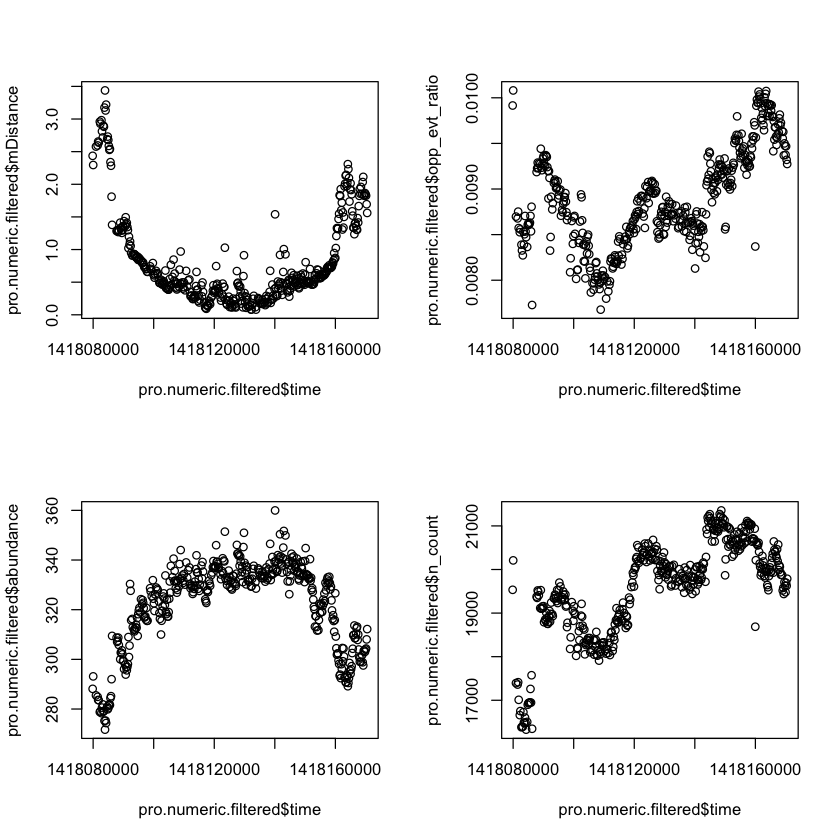

In [8]:
par(mfrow=c(2,2))
plot(pro.numeric.filtered$time, pro.numeric.filtered$mDistance)
plot(pro.numeric.filtered$time, pro.numeric.filtered$opp_evt_ratio)
plot(pro.numeric.filtered$time, pro.numeric.filtered$abundance)
plot(pro.numeric.filtered$time, pro.numeric.filtered$n_count)

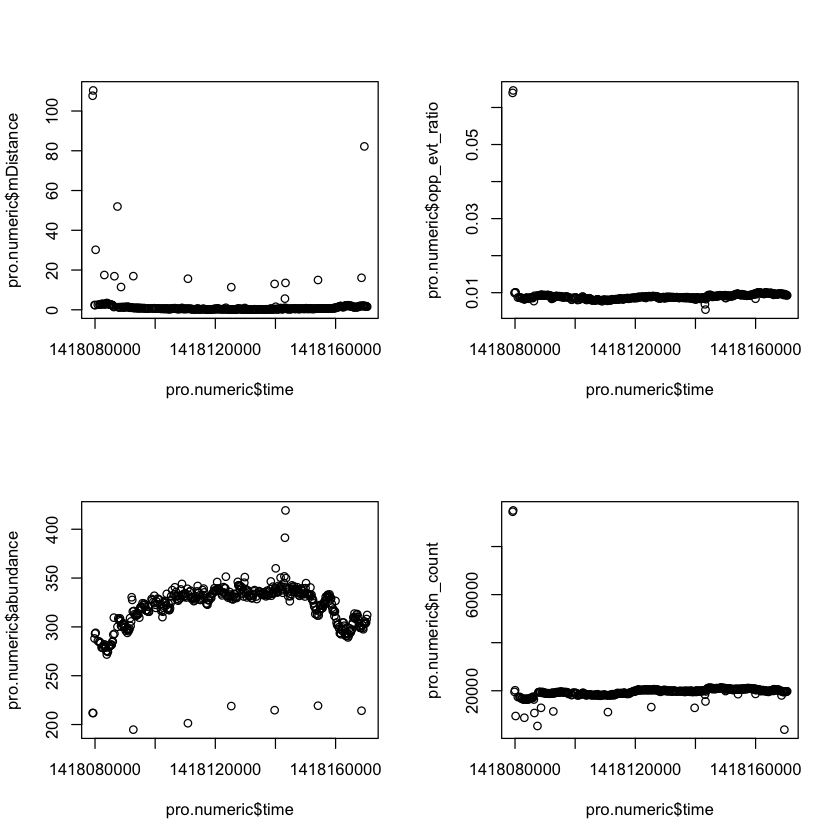

In [17]:
par(mfrow=c(2,2))
plot(pro.numeric$time, pro.numeric$mDistance)
plot(pro.numeric$time, pro.numeric$opp_evt_ratio)
plot(pro.numeric$time, pro.numeric$abundance)
plot(pro.numeric$time, pro.numeric$n_count)

## Using R's built in function
Does not support the weights, which might be just as well becasue I don't fully understand them....

In [36]:
# Reset out data
pro = stats[(stats$pop=="prochloro"),]
pro$time <- as.numeric(pro$time)
pro.numeric = pro[,c("time", "opp_evt_ratio", "abundance", "n_count")]

In [37]:
center <- colMeans(pro.numeric)
cov <- var(pro.numeric)
mDistance2 <- mahalanobis(pro.numeric, center, cov)

In [38]:
pro.numeric <- as.data.frame(pro.numeric)
pro.numeric$mDistance2 <- mDistance2

fact.sd <- 0.5
pre.out <- which(mDistance2 < -fact.sd*sd(mDistance2) | mDistance2 > fact.sd*sd(mDistance2))
pro.numeric.filtered2 <- pro.numeric[-c(pre.out),]

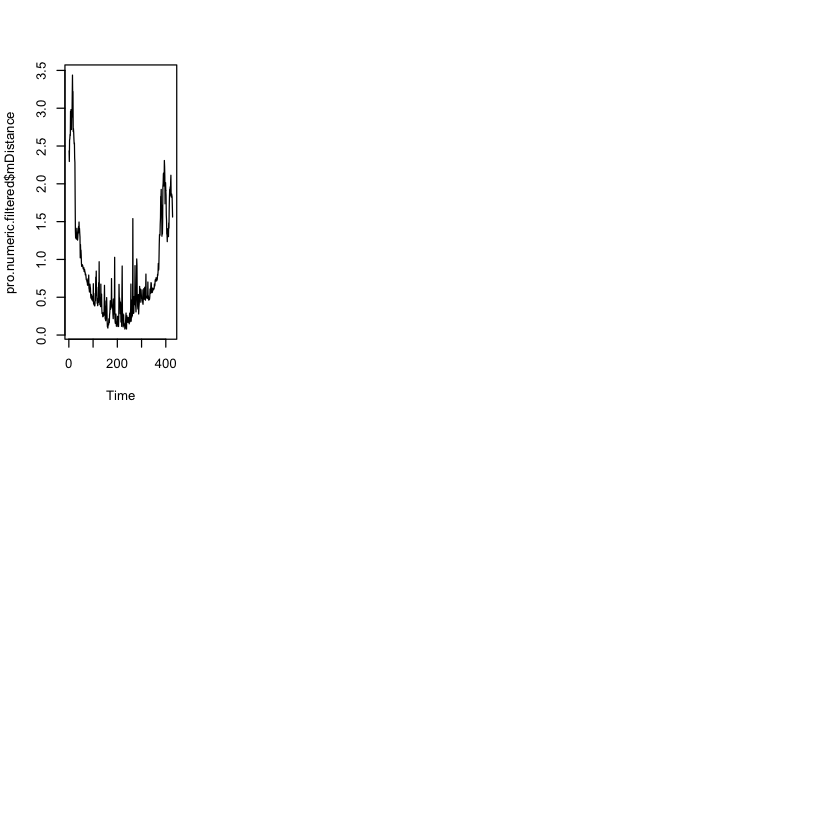

In [40]:
# Lets compare R's built in method to the WMBD package...
# Well.. looks like they're exaclty the same

par(mfrow=c(2,4))
plot(pro.numeric.filtered$time, pro.numeric.filtered$mDistance)
plot(pro.numeric.filtered2$time, pro.numeric.filtered2$mDistance)

plot(pro.numeric.filtered$time, pro.numeric.filtered$opp_evt_ratio)
plot(pro.numeric.filtered2$time, pro.numeric.filtered2$opp_evt_ratio)

plot(pro.numeric.filtered$time, pro.numeric.filtered$abundance)
plot(pro.numeric.filtered2$time, pro.numeric.filtered2$abundance)

plot(pro.numeric.filtered$time, pro.numeric.filtered$n_count)
plot(pro.numeric.filtered2$time, pro.numeric.filtered2$n_count)

## The Math
The formula for the Mahalanobis distance of an observation $\vec{x} = (x_1, x_2, ... , x_n)^T$ form a set of obersvations with mean $\vec{u}=(u_1, u_2, ... , u_n)^T$ and a covariance matrix S is defined by:

$D_M\vec{x} = \sqrt{(\vec{x}-\vec{u})^T S^{-1} (\vec{x}-\vec{u})}$ 

### Estimating the Covariance Matrix
